# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [1]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [2]:
!pip install wntr
!pip install scipy
!pip install tqdm
%matplotlib inline

import wntr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from sklearn.metrics import confusion_matrix, recall_score, precision_score

     |████████████████████████████████| 4.2 MB 5.0 MB/s 


In [58]:
import utils
import models
from utils.Network import WDN
from utils.Dataloader import Dataloader
from utils.Datagenerator import Datagenerator
from models.Classification import ClassificationModel

from utils.helper import any_transform
from utils.metrics import print_metrics

# Attention: Run twice for real reload effect
import importlib
importlib.reload(utils.helper)
importlib.reload(utils.metrics)
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)
importlib.reload(utils.Datagenerator)
importlib.reload(models.Classification)

<module 'models.Classification' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/models/Classification.py'>

## Main

### Plotting

In [4]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

def show_data(X, y):
  # Get Leakage time
  first_leakage_at = np.argmax(y)
  print('Leakage at', first_leakage_at, 'Day', first_leakage_at // 24, 'Hour', first_leakage_at % 24)

  # Plot window around leakage time
  plot(X.loc[first_leakage_at-3*24:first_leakage_at+3*24, X.columns != 'hour of the day'], line_at=[first_leakage_at], location="lower left")

  # Plot whole data including y
  Xy = X.copy()
  Xy['y'] = y * (96 - 71) + 71
  plot(Xy.loc[:, Xy.columns != 'hour of the day'], location="lower left")

def print_metrics(y_true, y_pred):
  print(confusion_matrix(y_true, y_pred))
  print(f'Recall (Sns): {round(recall_score(y_true, y_pred), 3)}\tWie gut wurden echte Lecks erkannt?')
  print(f'Specificity:  {round(recall_score(y_true, y_pred, pos_label=0), 3)}\tWie gut wurde \'alles ok\' erkannt?')
  print(f'Precision:    {round(precision_score(y_true, y_pred), 3)}\tWie viele erkannte lecks waren auch wirklich Lecks?')

### Ergebnisse:



SVM ohne 'Time of Day':
```
[[102  24]
 [ 30  25]]
Recall:      0.455
Precision:   0.51
Specificity: 0.81
```
SVM mit 'Time of Day':
```
[[104  16]
 [ 24  37]]
Recall:      0.607
Precision:   0.698
Specificity: 0.867
```


Confusion Matrix:
```
[[TN  FP]
 [FN  TP]]
```
- **Sensitivity/ Recall**: Wie gut wurden echte Lecks erkannt?
- **Precision**: Wie viele erkannte lecks waren auch wirklich Lecks?
- **Specificity**: Wie gut wurde 'alles ok' erkannt?


Median Filter 1
Recall:      0.567
Precision:   0.882
Specificity: 0.955

Median Filter 3
Recall:      0.56
Precision:   0.969
Specificity: 0.989

Median Filter 5
Recall:      0.551
Precision:   1.0
Specificity: 1.0

Median Filter 11
Recall:      0.529
Precision:   1.0
Specificity: 1.0

Plan:
- Eigene Klasse "Klassifikator" erbt von `BaseEstimator` inkl. `.fit()` und `.predict()`
- Darin `.score()` mit automaischer Konvertierung
- Vorbereiten für eigenes GridSearch
- Train-Test-Split mit einzelne Aufrufen von `get_single_data()` als Datenpunkte

### Testing

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


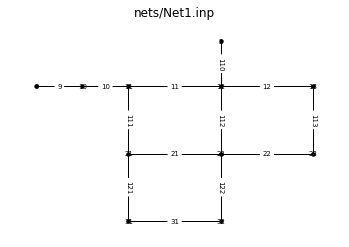

In [5]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()
gen = Datagenerator(wdn)

In [33]:
X, y = gen.gen_dataset(size=50*6)

Generating 150 leakage scenarios...


100%|██████████| 150/150 [04:32<00:00,  1.82s/it]


Generating 150 non leakage scenarios...


100%|██████████| 150/150 [04:13<00:00,  1.69s/it]


In [59]:
from sklearn.model_selection import KFold

import random

ab = list(zip(X, y))

random.shuffle(ab)

X, y = map(list, list(zip(*ab)))

In [66]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from tqdm import tqdm
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

results = {}
for m in tqdm([SVC(gamma=0.001),
               SVC(gamma=0.002),
               SVC(gamma=0.003),
               KNeighborsClassifier(n_neighbors=3),
               KNeighborsClassifier(n_neighbors=5),
               KNeighborsClassifier(n_neighbors=7),
               MLPClassifier(hidden_layer_sizes=(18,10)),
               MLPClassifier(hidden_layer_sizes=(18,20,30)),
               MLPClassifier(hidden_layer_sizes=(12,)),
               MLPClassifier(hidden_layer_sizes=(18,)),
               MLPClassifier(hidden_layer_sizes=(18,10,5, 4))]):
  model = ClassificationModel(m, medfilt_kernel_size=5)
  cv_results = cross_validate(model, X, y, cv=5, scoring=scoring)
  metrics = []
  for metric in ['test_accuracy', 'test_recall', 'test_specificity', 'test_precision', 'test_detection_time']:
    metrics.append(round(cv_results[metric].mean(), 3)) # TODO filter -1
  results[m] = metrics
  #print('\nResults for', m)
  #print_metrics(y_test, y_pred)
df = pd.DataFrame(results).T
df.columns = 'accuracy', 'recall', 'specificity', 'precision', 'detection_time'
df

 73%|███████▎  | 8/11 [05:21<02:04, 41.63s/it]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 82%|████████▏ | 9/11 [05:46<01:12, 36.30s/it]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 91%|█████████ | 10/11 [06:19<00:35, 3

,accuracy,recall,specificity,precision,detection_time
SVC(gamma=0.001),0.993,0.987,1.000,1.000,8.479
SVC(gamma=0.002),1.000,1.000,1.000,1.000,7.470
SVC(gamma=0.003),1.000,1.000,1.000,1.000,6.687
KNeighborsClassifier(n_neighbors=3),1.000,1.000,1.000,1.000,1.282
KNeighborsClassifier(),1.000,1.000,1.000,1.000,1.455
KNeighborsClassifier(n_neighbors=7),1.000,1.000,1.000,1.000,1.569
"MLPClassifier(hidden_layer_sizes=(18, 10))",0.870,0.805,0.994,0.993,16.537
"MLPClassifier(hidden_layer_sizes=(18, 20, 30))",1.000,1.000,1.000,1.000,9.033
"MLPClassifier(hidden_layer_sizes=(12,))",0.627,0.258,1.000,0.600,11.253
"MLPClassifier(hidden_layer_sizes=(18,))",0.807,0.580,1.000,0.800,15.074


In [60]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

model = ClassificationModel(KNeighborsClassifier(n_neighbors=3), medfilt_kernel_size=5)

cv_results = cross_validate(model, X, y, cv=10, scoring=scoring)

In [61]:
cv_results

{'fit_time': array([0.074, 0.073, 0.068, 0.071, 0.072]),
 'score_time': array([0.667, 0.637, 0.682, 0.696, 0.693]),
 'test_accuracy': array([1., 1., 1., 1., 1.]),
 'test_detection_time': array([1.346, 1.25 , 1.433, 1.148, 1.231]),
 'test_precision': array([1., 1., 1., 1., 1.]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'test_specificity': array([1., 1., 1., 1., 1.])}

In [63]:
cv_results['test_detection_time'].mean()

1.2816809116809116

In [64]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_recall', 'test_specificity', 'test_precision', 'test_detection_time'])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)


from collections import Counter

y_train_any, y_test_any = any_transform(y_train, y_test)

print(Counter(y_train_any))
print(Counter(y_test_any))

Counter({1: 117, 0: 108})
Counter({0: 42, 1: 33})


In [10]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from tqdm import tqdm

results = {}
for m in tqdm([SVC(gamma=0.001),
               SVC(gamma=0.002),
               SVC(gamma=0.003),
               KNeighborsClassifier(n_neighbors=3),
               KNeighborsClassifier(n_neighbors=5),
               KNeighborsClassifier(n_neighbors=7),
               MLPClassifier(hidden_layer_sizes=(18,10)),
               MLPClassifier(hidden_layer_sizes=(18,20,30)),
               MLPClassifier(hidden_layer_sizes=(12,)),
               MLPClassifier(hidden_layer_sizes=(18,)),
               MLPClassifier(hidden_layer_sizes=(18,10,5, 4))]):
  model = ClassificationModel(m, medfilt_kernel_size=5)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  metrics = []
  for metric in [accuracy, recall, specificity, precision, detection_time]:
    metrics.append(round(metric(y_test, y_pred), 3))
  results[m] = metrics
  #print('\nResults for', m)
  #print_metrics(y_test, y_pred)
df = pd.DataFrame(results).T
df.columns = 'accuracy', 'recall', 'specificity', 'precision', 'detection_time'
df

100%|██████████| 11/11 [02:09<00:00, 11.75s/it]


,accuracy,recall,specificity,precision,detection_time
SVC(gamma=0.001),0.973,0.939,1.0,1.0,9.355
SVC(gamma=0.002),1.000,1.000,1.0,1.0,8.879
SVC(gamma=0.003),1.000,1.000,1.0,1.0,7.818
KNeighborsClassifier(n_neighbors=3),1.000,1.000,1.0,1.0,1.182
KNeighborsClassifier(),1.000,1.000,1.0,1.0,1.242
KNeighborsClassifier(n_neighbors=7),1.000,1.000,1.0,1.0,1.545
"MLPClassifier(hidden_layer_sizes=(18, 10))",0.987,0.970,1.0,1.0,9.656
"MLPClassifier(hidden_layer_sizes=(18, 20, 30))",1.000,1.000,1.0,1.0,10.030
"MLPClassifier(hidden_layer_sizes=(12,))",0.987,0.970,1.0,1.0,10.969
"MLPClassifier(hidden_layer_sizes=(18,))",0.973,0.939,1.0,1.0,15.903


In [ ]:
from sklearn.svm import SVC

# Create the model
model = ClassificationModel(SVC(gamma=0.001), medfilt_kernel_size=5)

# Learn on the train subset
model.fit(X_train, y_train)

# Predict on the test subset
y_pred = model.predict(X_test)

# Show Results
print_metrics(y_test, y_pred)

[[35  0]
 [ 1 39]]
Accuracy:     0.987	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.975	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Mean Detection Time: 8.077	Wie viele Stunden dauerte es bis zum erkennen?


Leakage at 451 Day 18 Hour 19


<Figure size 432x288 with 0 Axes>

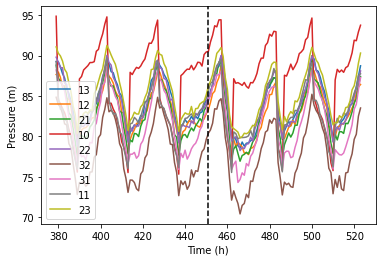

<Figure size 432x288 with 0 Axes>

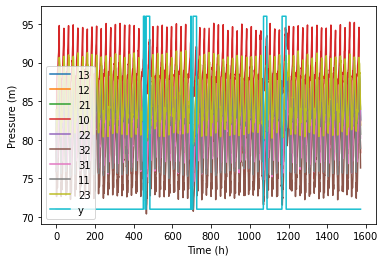

[[1410    0]
 [  76   87]]
Recall (Sns): 0.534	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Accuracy:     1.0


array([[9, 0],
       [0, 4]])

In [ ]:
X_show = pd.concat(X_test)
y_show = np.concatenate(y_pred)
X_show.reset_index(drop=True, inplace=True)

y_true_show = np.concatenate(y_test)

show_data(X_show, y_show)

print_metrics(y_true_show, y_show)

print('Accuracy:    ', model.score(X_test, y_test))

preds = model.predict(X_test)

confusion_matrix(*any_transform(y_test, preds))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create the model
model = ClassificationModel(KNeighborsClassifier(), medfilt_kernel_size=5)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = model.predict(X_test)

Leakage at 79 Day 3 Hour 7


<Figure size 432x288 with 0 Axes>

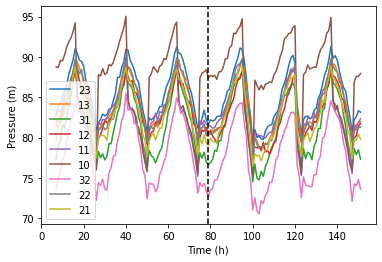

<Figure size 432x288 with 0 Axes>

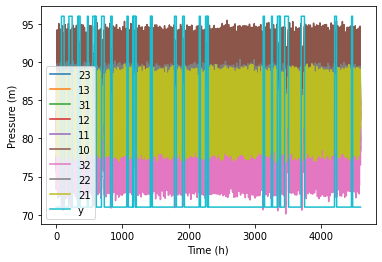

[[3852    0]
 [  62  684]]
Recall (Sns): 0.917	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Accuracy:     1.0


array([[17,  0],
       [ 0, 21]])

In [ ]:
X_show = pd.concat(X_test)
y_show = np.concatenate(y_pred)
X_show.reset_index(drop=True, inplace=True)

y_true_show = np.concatenate(y_test)

show_data(X_show, y_show)

print_metrics(y_true_show, y_show)

print('Accuracy:    ', model.score(X_test, y_test))

preds = model.predict(X_test)

confusion_matrix(*any_transform(y_test, preds))

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create the model
model = ClassificationModel(MLPClassifier(hidden_layer_sizes=(18,20,10)), medfilt_kernel_size=5)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = model.predict(X_test)

Leakage at 87 Day 3 Hour 15


<Figure size 432x288 with 0 Axes>

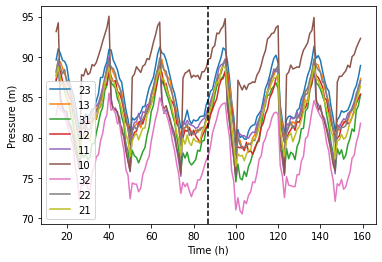

<Figure size 432x288 with 0 Axes>

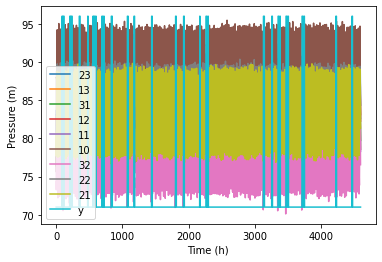

[[3852    0]
 [ 439  307]]
Recall (Sns): 0.412	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Accuracy:     1.0


array([[17,  0],
       [ 0, 21]])

In [ ]:
X_show = pd.concat(X_test)
y_show = np.concatenate(y_pred)
X_show.reset_index(drop=True, inplace=True)

y_true_show = np.concatenate(y_test)

show_data(X_show, y_show)

print_metrics(y_true_show, y_show)

print('Accuracy:    ', model.score(X_test, y_test))

preds = model.predict(X_test)

confusion_matrix(*any_transform(y_test, preds))